## 2 - Image Stitching
John Wu - 260612056

### 2.1 Coding Questions
You are given three diﬀerent views of the same scene in a folder ‘stitching images’ (Figure 1). Follow these steps in order to stitch given images:


#### 1. Compute SIFT keypoints and corresponding descriptors for images 1Hill and 2Hill. 

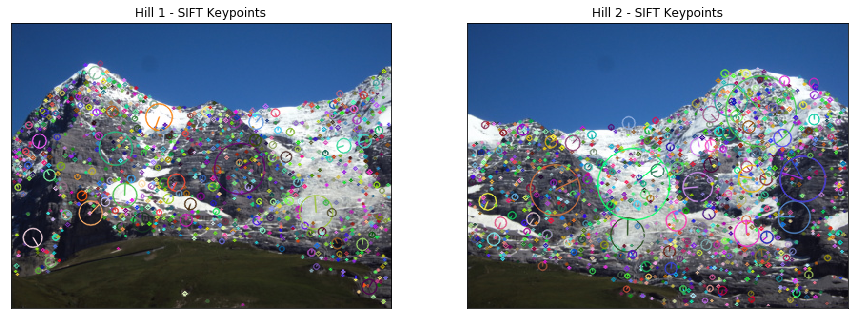

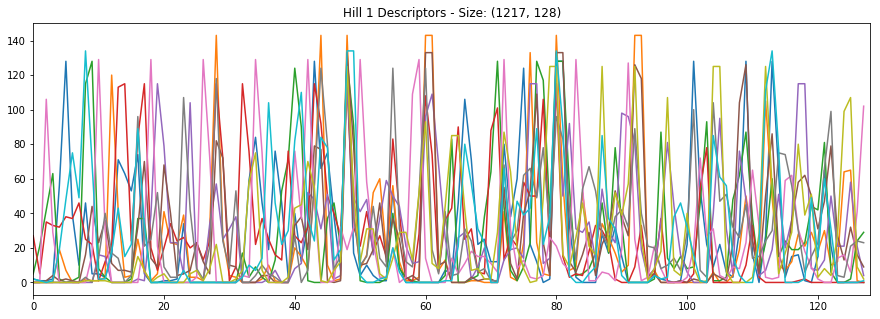

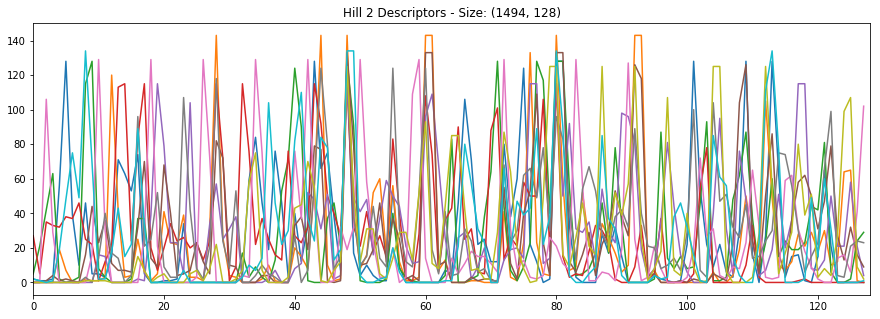

In [23]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# read images
hill1 = cv2.imread('./stitching_images/1Hill.JPG')
hill2 = cv2.imread('./stitching_images/2Hill.JPG')

# convert to RGB color
hill1 = cv2.cvtColor(hill1, cv2.COLOR_BGR2RGB)
hill2 = cv2.cvtColor(hill2, cv2.COLOR_BGR2RGB)

# compute keypoints and descriptors
sift = cv2.xfeatures2d.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(hill1, None)
keypoints2, descriptors2 = sift.detectAndCompute(hill2, None)

# draw the keypoints
hill1_c = hill1.copy()
hill2_c = hill2.copy()
cv2.drawKeypoints(hill1, keypoints1, hill1_c, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(hill2, keypoints2, hill2_c, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# display keypoints 
plt.figure(figsize=(15,7))
plt.subplot(121), plt.imshow(hill1_c)
plt.title("Hill 1 - SIFT Keypoints"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(hill2_c)
plt.title("Hill 2 - SIFT Keypoints"), plt.xticks([]), plt.yticks([])
plt.show()

# display descriptors
plt.figure(figsize=(15, 5))
plt.title('Hill 1 Descriptors - Size: ' + str(descriptors1.shape))
for i in range(10):
    plt.plot(descriptors1[i])
    plt.xlim([0,128]) 
plt.show()

plt.figure(figsize=(15, 5))
plt.title('Hill 2 Descriptors - Size: ' + str(descriptors2.shape))
for i in range(10):
    plt.plot(descriptors1[i])
    plt.xlim([0,128]) 
plt.show()

#### 2. Find matching keypoints in two images and display the 20 best pairs. 

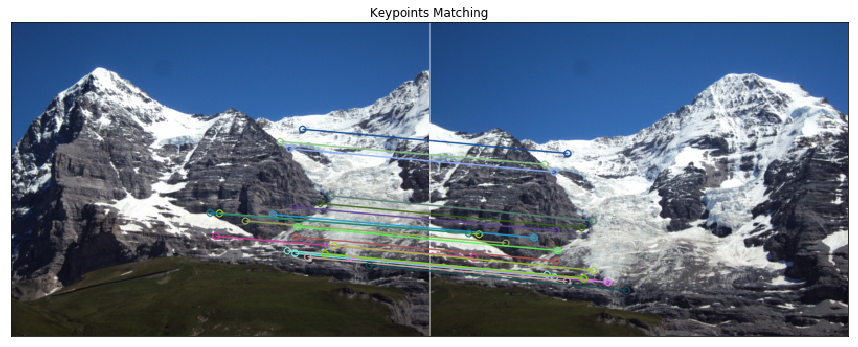

In [24]:
# create BFMatcher object
bf = cv2.BFMatcher() 

# match descriptors.
matches = bf.match(descriptors1, descriptors2)

# sort in the order of their distances
matches = sorted(matches, key = lambda x:x.distance)

# draw keypoints 
imgmatch = cv2.drawMatches(hill1,keypoints1,hill2,keypoints2, matches[:20], hill1, flags=2)

# display results
plt.figure(figsize=(15,15))
plt.imshow(imgmatch)
plt.title("Keypoints Matching"), plt.xticks([]), plt.yticks([])
plt.show()

#### 3. Find homography using RANSAC method and apply transformation to 1Hill. Image 2Hill should not be transformed.

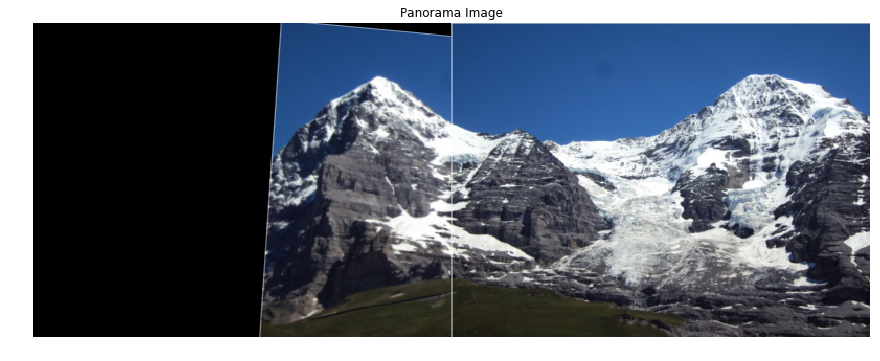

In [36]:
# arrange matching keypoints in two separate lists
good_matches = []
for i, m in enumerate(matches):
    good_matches.append((m.trainIdx, m.queryIdx))

mp1 = np.float32([keypoints2[i].pt for (i, __) in good_matches])
mp2 = np.float32([keypoints1[i].pt for (__, i) in good_matches])

# shift all the points in the right image over 
for i in range(len(mp1)):
    mp1[i][0] += hill2.shape[1]

# find homography and wrap image accordingly
H, __ = cv2.findHomography(mp2, mp1, cv2.RANSAC, 4)

# Get image dimensions.
h1, w1, _ = hill1.shape
h2, w2, _ = hill2.shape

# use homography to create warped image
warped_img = cv2.warpPerspective(hill1, H, (w1 + w2, h2))
glued = warped_img.copy()
glued[:, w2:,:] = hill2

# display results
plt.figure(figsize=(15,15))
plt.imshow(glued)
plt.title("Panorama Image"), plt.axis('off')
plt.show()

#### 4. Stitch transformed 1Hill and original 2Hill together using pyramid image blending.

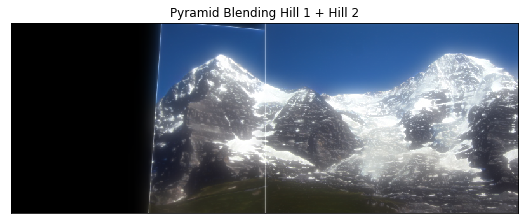

In [45]:
def Pyramid_Blending(left, right, depth=6):
    """
    Create pyramid blending function
    :param left: left image
    :param right: right image
    :param depth: depth of pyramid
    :return:
    """
    # generate Gaussian pyramid 
    gaussian_left, gaussian_right = left.copy(), right.copy()
    gp_left, gp_right = [gaussian_left], [gaussian_right]
    for i in range(depth):
        gaussian_left = cv2.pyrDown(gaussian_left)
        gp_left.append(gaussian_left)

        gaussian_right = cv2.pyrDown(gaussian_right)
        gp_right.append(gaussian_right)

    # generate laplacian Pyramid 
    lp_left, lp_right = [gp_left[depth-1]], [gp_right[depth-1]]
    for i in range(depth-1,0,-1):
        h_left, w_left, _ = gp_left[i-1].shape
        # Make sure that the destination size matches that of gp_left[i-1].
        L = cv2.subtract(gp_left[i-1],cv2.pyrUp(gp_left[i], dstsize=(w_left, h_left)))
        lp_left.append(L)

        h_right, w_right, _ = gp_right[i-1].shape
        # Make sure that the destination size matches that of gp_right[i-1].
        L = cv2.subtract(gp_right[i-1], cv2.pyrUp(gp_right[i], dstsize=(w_right, h_right)))
        lp_right.append(L)

    # stack images together at each Laplacian Pyramid level.
    LS = []
    for la,lb in zip(lp_left,lp_right):
        ls = np.hstack((la, lb))
        LS.append(ls)

    # blend and reconstruct the final image.
    rs = LS[0]
    for i in range(1,depth):
        h, w, _ = LS[i].shape
        rs = cv2.pyrUp(rs, dstsize=(w, h))
        rs = cv2.add(rs, LS[i])
    
    return rs.astype(np.uint8)

# apply pyramid blending
hill12 = Pyramid_Blending(warped_img[:,:w1], hill2, 5)

# display results
plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(hill12)
plt.title('Pyramid Blending Hill 12'), plt.xticks([]), plt.yticks([])
plt.show()